<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Introduction:-Trying-the-impossible!" data-toc-modified-id="Introduction:-Trying-the-impossible!-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Introduction: Trying the impossible!</a></span></li><li><span><a href="#Are-all-libraries-that-are-needed-available?" data-toc-modified-id="Are-all-libraries-that-are-needed-available?-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Are all libraries that are needed available?</a></span></li><li><span><a href="#Prepare-an-image-provider-class" data-toc-modified-id="Prepare-an-image-provider-class-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Prepare an image provider class</a></span></li><li><span><a href="#Build-a-MLP-model" data-toc-modified-id="Build-a-MLP-model-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Build a MLP model</a></span></li><li><span><a href="#Train-the-MLP-with-images" data-toc-modified-id="Train-the-MLP-with-images-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Train the MLP with images</a></span></li><li><span><a href="#Test-the-final-MLP-on-training-data" data-toc-modified-id="Test-the-final-MLP-on-training-data-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Test the final MLP on training data</a></span></li><li><span><a href="#Generating-new-test-images" data-toc-modified-id="Generating-new-test-images-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Generating new test images</a></span></li><li><span><a href="#Conclusions" data-toc-modified-id="Conclusions-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Conclusions</a></span></li></ul></div>

# Introduction: Trying the impossible!

A Convolutional Neural Network (NN) consists of two parts. A feature hierarchy with CONV and MAX-Pooling layers and a classificator on top of this feature hierarchy, usually a Multi Layer Perceptron (MLP).

But do we really need this feature hierarchy? Why not use images directly as input for a MLP? Never say never. So let's try the "impossible": learn to classify images without the feature hierarchy. Just using a MLP.

# Are all libraries that are needed available?

In [1]:
import numpy as np
import tensorflow as tf
import keras
import cv2

print( "Your NumPy version is: " + np.__version__ )
print( "Your TensorFlow version is: " + tf.__version__)
print( "Your Keras version is: " + keras.__version__ )
print( "Your OpenCV version is: " + cv2.__version__ )

Your NumPy version is: 1.13.3
Your TensorFlow version is: 1.5.1
Your Keras version is: 2.2.3
Your OpenCV version is: 3.4.1


Using TensorFlow backend.


# Prepare an image provider class

In [2]:
import os
from os import listdir
from os.path import isdir, isfile, join

IMG_SIZE = (100,100)
    
class image_provider:
    
    #
    # Traverses all subfolders of the specified root_folder
    # and generates a list of the form:
    #
    # [ ["data/bikes/jfksdj43.jpg", "bikes",
    #   ["data/cars/bvcnm401.jpg", "cars"],
    #   ...
    # ]
    #
    def __init__(self, root_folder):
        
        self.all_training_items = []
       
        class_names = \
            [d for d in listdir(root_folder)
             if isdir(os.path.join(root_folder,d))]

        print("Under folder", root_folder, "I found the following subfolders/classes:")
        print(class_names)
        
        nr_classes = len(class_names)
        
        # For each subfolder ...
        for class_id, class_name in enumerate(class_names):
            
            subfolder_name = root_folder + "/" + class_name + "/"
            
            filenames = \
                [subfolder_name + f
                 for f in listdir(subfolder_name) if isfile(join(subfolder_name, f))]
            
            print("{} files in subfolder {}".format(len(filenames), subfolder_name) )
            
            # For each image filename in current subfolder ...
            for filename in filenames:
                
                teacher_vec = np.zeros( nr_classes )
                teacher_vec[class_id] = 1.0
                
                self.all_training_items.append(
                    [filename, class_id, class_name, teacher_vec] )              
        
        self.nr_images = len(self.all_training_items)
        print("There are {} images in total available.".format(self.nr_images))
        
    
    
    #   
    # Given an absolute filename,
    # load the image in using OpenCV,
    # then convert it to usual RGB color channel order
    # and scale values to be in range [0,1]
    #
    def load_image(self, absolute_filename):
        
        image = cv2.imread(absolute_filename)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        # invert image
        image = 255 - image
        
        image = cv2.resize(image, IMG_SIZE, interpolation=cv2.INTER_AREA)
        image = image * (1.0 / 255.0)
        
        return image
        
        
       
    #
    # Return the image from the dataset
    # with the specified index
    #
    def get_specific_image(self, idx):
        
        image_filename  = self.all_training_items[idx][0]
        class_id        = self.all_training_items[idx][1]
        class_name      = self.all_training_items[idx][2]
        teacher_vec     = self.all_training_items[idx][3]
        
        image = self.load_image(image_filename)
        
        return image, class_id, class_name, teacher_vec
    
    
    #
    # Return an OpenCV image and the class label
    # where the image is chosen randomly from the
    # list of all images.
    #
    def get_random_image(self):
        
        rnd_idx = np.random.randint(0, self.nr_images)
        return self.get_specific_image( rnd_idx )


Let's test the image provider class:

In [3]:
my_image_provider = image_provider( "data_digits" )

Under folder data_digits I found the following subfolders/classes:
['1', '2']
10 files in subfolder data_digits/1/
10 files in subfolder data_digits/2/
There are 20 images in total available.


Let us retrieve randomly one of the images and display it.

image has type <class 'numpy.ndarray'>
image has shape (100, 100, 3)
teacher vec: [ 1.  0.]


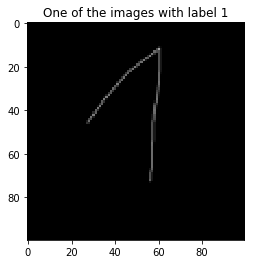

In [4]:
import matplotlib.pyplot as plt

image, class_id, class_name, teacher_vec = \
    my_image_provider.get_random_image()
print("image has type", type(image))
print("image has shape", image.shape)
print("teacher vec:", teacher_vec)
plt.imshow(image)
plt.title("One of the images with label {}".format(class_name))
plt.show()

# Build a MLP model

In [5]:
from keras.models import Sequential
from keras import layers
from keras.layers.core import Dense
from keras import backend as K

nr_channels = 3
input_vec_dim = IMG_SIZE[0] * IMG_SIZE[1] * nr_channels
print("Input vectors for this MLP will have length", input_vec_dim)

K.clear_session()

model = Sequential()
model.add(Dense(2, activation="linear", input_dim=input_vec_dim))

model.summary()

model.compile(loss='mean_squared_error', optimizer='sgd')

Input vectors for this MLP will have length 30000
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 2)                 60002     
Total params: 60,002
Trainable params: 60,002
Non-trainable params: 0
_________________________________________________________________


# Train the MLP with images

In [6]:
NR_TRAIN_IMAGES = 1000

for train_img_idx in range(0,NR_TRAIN_IMAGES):
    
    if train_img_idx % 100 == 0:
        print("Trained on {} images so far...".
             format(train_img_idx))

    # Get a random image from the image provider
    image, class_id, class_name, teacher_vec = \
        my_image_provider.get_random_image()
    
    # Show the training image?
    if False:
        plt.imshow(image)
        plt.title("Training image with label {}".format(class_name))
        plt.show()
    
    # Flatten the 3D input image to a 1D input vector
    input_vec = image.flatten()
        
    #print("image has shape", image.shape)
    #print("input_vec has shape", input_vec.shape)
    #print("teacher_vec is", teacher_vec)
    #print(input_vec)
    
    input_vec = input_vec.reshape( (1, input_vec.shape[0]) )
    teacher_vec = teacher_vec.reshape( (1, teacher_vec.shape[0]) )
    #print("input_vec has shape", input_vec.shape)
    #print("teacher_vec has shape", teacher_vec.shape)
            
    model.fit(input_vec, teacher_vec, epochs=1, verbose=0)
    
print("Training finished!")

Trained on 0 images so far...
Trained on 100 images so far...
Trained on 200 images so far...
Trained on 300 images so far...
Trained on 400 images so far...
Trained on 500 images so far...
Trained on 600 images so far...
Trained on 700 images so far...
Trained on 800 images so far...
Trained on 900 images so far...
Training finished!


# Test the final MLP on training data

Now let us see how good the trained MLP performs on the same data on which we trained it: the training data.

In [7]:
# No images correctly classified so far
correctly_classified = 0

for img_idx in range(0, my_image_provider.nr_images):
    
    print("\nTesting with training image {}".
             format(img_idx))

    # Get image from image provider
    image, gt_class_id, gt_class_name, teacher_vec = \
        my_image_provider.get_specific_image( img_idx )
    
    # Flatten the 3D input image to a 1D input vector
    input_vec = image.flatten()
    
    # Inputs for predit method have to be 2D
    input_vec = input_vec.reshape( (1, input_vec.shape[0]) )
    teacher_vec = teacher_vec.reshape( (1, teacher_vec.shape[0]) )
    
    # Let the MLP predict the class!
    neuron_outputs = model.predict(input_vec)
    print("output neuron values are:", neuron_outputs)
    
    # Get final prediction result:
    # Which of the n output neurons has the largest output?
    predicted_class_id = np.argmax(neuron_outputs.reshape(-1))
        
    # Show comparison of predicted vs. ground-truth label
    print("predicted: {} vs. real: {}".
          format(predicted_class_id, gt_class_id))
    
    # Compute correct classification rate
    if predicted_class_id==gt_class_id:
        correctly_classified += 1
        
print("\n---\nCorrectly classified {} of {} images.".
      format(correctly_classified, my_image_provider.nr_images))


Testing with training image 0
output neuron values are: [[  9.99995530e-01   3.16277146e-06]]
predicted: 0 vs. real: 0

Testing with training image 1
output neuron values are: [[  1.00000012e+00  -2.68220901e-07]]
predicted: 0 vs. real: 0

Testing with training image 2
output neuron values are: [[  9.99997079e-01   2.18302011e-06]]
predicted: 0 vs. real: 0

Testing with training image 3
output neuron values are: [[  9.99999225e-01   5.55068254e-07]]
predicted: 0 vs. real: 0

Testing with training image 4
output neuron values are: [[  9.99994576e-01   3.71783972e-06]]
predicted: 0 vs. real: 0

Testing with training image 5
output neuron values are: [[  9.99983609e-01   1.25207007e-05]]
predicted: 0 vs. real: 0

Testing with training image 6
output neuron values are: [[  9.99999285e-01   6.22123480e-07]]
predicted: 0 vs. real: 0

Testing with training image 7
output neuron values are: [[  1.00000930e+00  -6.52298331e-06]]
predicted: 0 vs. real: 0

Testing with training image 8
output ne

# Generating new test images

In order to generate new test images, we just shift the digits some pixels to the right.

Tested on 0 test images so far...


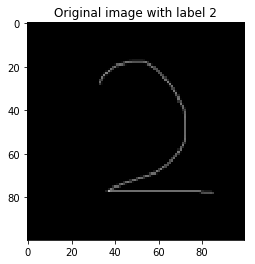

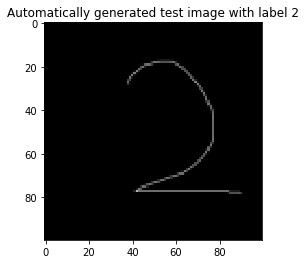

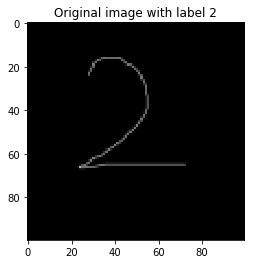

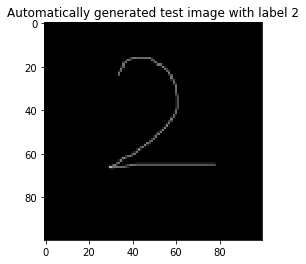

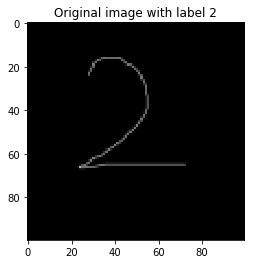

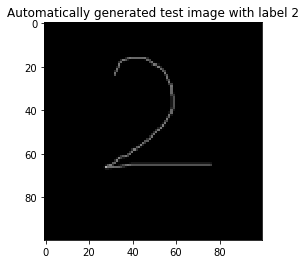

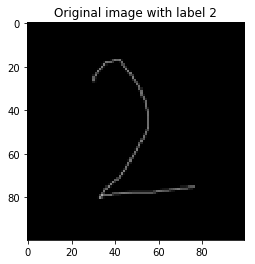

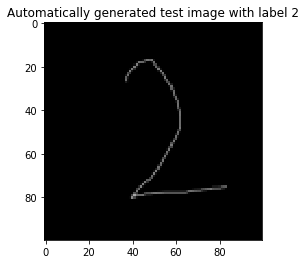

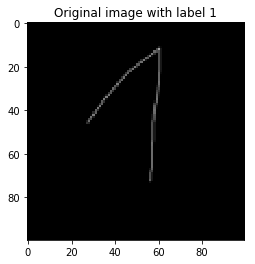

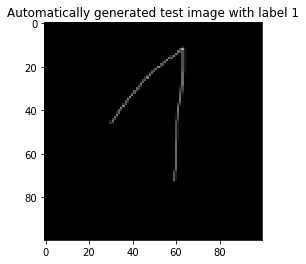

Tested on 100 test images so far...
Tested on 200 test images so far...
Tested on 300 test images so far...
Tested on 400 test images so far...
Tested on 500 test images so far...
Tested on 600 test images so far...
Tested on 700 test images so far...
Tested on 800 test images so far...
Tested on 900 test images so far...

---
Correctly classified 513 of 1000 images.


In [11]:
# No images correctly classified so far
correctly_classified = 0

NR_TEST_IMAGES = 1000

for test_img_idx in range(0,NR_TEST_IMAGES):
    
    if test_img_idx % 100 == 0:
        print("Tested on {} test images so far...".
             format(test_img_idx))
    
    # Get a random image from the image provider
    image, class_id, class_name, teacher_vec = \
        my_image_provider.get_random_image()
        
    # Shift this original image a little bit to the right
    # in order to generate a new random image
    image2 = np.zeros( image.shape )
    MIN_SHIFT = 1
    MAX_SHIFT = 10
    rnd_shift = np.random.randint(MIN_SHIFT, MAX_SHIFT)
    nr_rows = image.shape[0]
    nr_cols = image.shape[1]
    for row_idx in range(0,nr_rows):
        image2[row_idx][rnd_shift:] = image[row_idx][0:nr_cols-rnd_shift]
        
    # Show the original and the new image?
    # Only for the first 5 test images, else:
    # too much output!
    if test_img_idx < 5:
        plt.imshow(image)
        plt.title("Original image with label {}".format(class_name))
        plt.show()
        plt.imshow(image2)
        plt.title("Automatically generated test image with label {}".
                  format(class_name))
        plt.show()
    
    # Prepare input for the MLP
    input_vec = image.flatten()    
    input_vec = input_vec.reshape( (1, input_vec.shape[0]) )
    teacher_vec = teacher_vec.reshape( (1, teacher_vec.shape[0]) )
            
    # Let the MLP predict the class!
    neuron_outputs = model.predict(input_vec)
    #print("output neuron values are:", neuron_outputs)
    
    # Get final prediction result:
    # Which of the n output neurons has the largest output?
    predicted_class_id = np.argmax(neuron_outputs.reshape(-1))
        
    # Show comparison of predicted vs. ground-truth label
    #print("predicted: {} vs. real: {}".
    #      format(predicted_class_id, gt_class_id))
    
    # Compute correct classification rate
    if predicted_class_id==gt_class_id:
        correctly_classified += 1
        
print("\n---\nCorrectly classified {} of {} images.".
      format(correctly_classified, NR_TEST_IMAGES))

# Conclusions

The test of this MLP for image classification shows.

It performs perfectly on the training data, since it used it huge sets of parameters to directly map the few input images to the desired output values.

However, on new images (just translated variants of the original image), the MLP is not besser than randomly guessing the class of the image.

By this we show that image classification with a MLP is not a good idea. Instead, we need another model that is able to come up with a representation of the image that is (mostly) invariant to translations (and all the other transformations, e.g. rotation).

This will lead us to the Convolutional Neural Networks (CNN).
